# Code Functionality:
## Used to create SOSS stellar model files (.dat) from PHOENIX stellar model files (.RF.h5.gz)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.optimize import curve_fit
from time import time

from sys import path as sys_path
sys_path.append("../../frosty_code/")

from os import path as os_path
from os import linesep, listdir, remove, mkdir

import h5py
import gzip
import shutil

import PHOENIX_to_SOSS as p2s

import warnings
from scipy.optimize import OptimizeWarning

# Function Definitions

In [2]:
def rescale(x, new_range=[0,1]):
    x = np.array(x)
    left, right = new_range
    a = (right - left)/(x.max() - x.min())
    b = left - a*x.min()
    x_mapped = a*x + b
    return x_mapped

def is_within(x,range_):
    boo = np.full( len(x) , False )
    for i in range(len(x)):
        if range_[0] <= x[i] <= range_[1]:
            boo[i] = True
    return boo

def chisquare( y_data , y_fit , sigma=1 , reduced=False ):
    if reduced: v = len(y_data) - 4
    else: v = 1
    return np.sum(((y_data-y_fit)/sigma)**2) / v

In [3]:
def SOSS_limbdark_func( mu , *pars ):
    a1,a2,a3,a4 = pars
    if type(mu) is list: mu = np.array(mu)
    I = 1 - a1*(1-np.power(mu,0.5)) - a2*(1-np.power(mu,1)) - a3*(1-np.power(mu,1.5)) - a4*(1-np.power(mu,2))
    return I

def SOSS_limbdark_func_penalizeON( mu , *pars ):
    a1,a2,a3,a4 = pars
    if type(mu) is list: mu = np.array(mu)
    I = 1 - a1*(1-np.power(mu,0.5)) - a2*(1-np.power(mu,1)) - a3*(1-np.power(mu,1.5)) - a4*(1-np.power(mu,2))
    I_at0 = SOSS_limbdark_func( 0 , *pars )
    if I_at0 < 0:
        return I + (I_at0 * 1e5)
    return I

def SOSS_limbdark_func_2( mu , *pars ):
    a1,a2,a3,a4 , x0 = pars
    if type(mu) is list: mu = np.array(mu)
    return 1 - a1*(1-np.power(mu+x0,0.5)) - a2*(1-np.power(mu+x0,1)) - a3*(1-np.power(mu+x0,1.5)) - a4*(1-np.power(mu+x0,2))

def SOSS_limbdark_func_3( mu , *pars , in_fit=True):
    a1,a2,a3,a4 , x0,y0 = pars
    if type(mu) is list: mu = np.array(mu)
    if in_fit and np.min(mu) + x0 < 0:
        return 1e10
    return 1 - a1*(1-np.power(mu+x0,0.5)) - a2*(1-np.power(mu+x0,1)) - a3*(1-np.power(mu+x0,1.5)) - a4*(1-np.power(mu+x0,2))  + y0

In [9]:
def PHOENIX_to_SOSS( phoenix_fpath , phoenix_fname , ld_guess=[] , ld_bounds=(-1*np.inf,np.inf)
                   , sosstar_fpath=None , sosstar_fname=None , force_write=False
                   , wl_inds=[None,None] , wl_range=[None,None]
                   , mu_inds=[None,None] , mu_range=[None,None] , I_range=[None,None]
                   , doPrint=False , doPlot=False , save=False , delete_hdf5=True
                   , force_positive_I=True , use_wav_ref_file=(True,None)
                   ):
    
    t0 = time()
    
    
    # Initalize the soss_file. Will be written to line by line
    if sosstar_fpath == None or sosstar_fpath == "": sosstar_fpath = "SOSS_starfiles/"
    if sosstar_fname == None:
        sosstar_fname = phoenix_fname.replace(".h5.gz",".simu-SOSS.dat")
    if not os_path.isdir(sosstar_fpath):
        mkdir(sosstar_fpath)
    if save and os_path.isfile(sosstar_fpath+sosstar_fname) and os_path.getsize(sosstar_fpath+sosstar_fname) > 0:
        if not force_write:
            print("\tSOSS file name already exits and contains data")
            print("\tAs a precaution, file won't be written to.")
            print("\tSet 'force_write'=True or delete the file to be able to write to that filename")
            return
        else:
            print("\tCaution. Currently writing to an existing file with size > 0 because argument 'force_write'=True")
    with open( sosstar_fpath+sosstar_fname , 'a' ) as sosstar_file:
    
    
        # Unzip phoenix file using gzip (assumes .gz file extension)
        # Creates a temporary hdf5 file in the working directory (deleted once the file is processed)
        if not os_path.exists( phoenix_fname[:-3] ):
            unzipped = True
            if doPrint: t1 = time()
            with gzip.open( phoenix_fpath+phoenix_fname , 'rb') as f_gunzip:
                with open(phoenix_fname[:-3], 'wb') as f_hdf5:
                    shutil.copyfileobj(f_gunzip, f_hdf5)
            if doPrint: print( "Time to gunzip file = " + str(round(time()-t1,2)) + ' secs\n')
        else:
            unzipped = False

            
        # Open the newly created hdf5 file and find the dataset
        with h5py.File(phoenix_fname[:-3] , 'r') as f:

            group_key_phoenixRF = list(f.keys())[0]      # file only has a single key on first level
            data_group = f[group_key_phoenixRF]          # Get the group containing the data needed
            n_mu = list(data_group['nmu'])[0]
            n_wl = list(data_group['nwl'])[0]
            mu = np.array((data_group['mu']))
            if doPrint:
                print("Data Groups:" , list(data_group))
                print(data_group['mu'])
                print(data_group['wl'])
                print(data_group['flux'])
                print(data_group['Intensities'] , '\n\n')

                
            # set the constants that dictate which wavelengths, mu and Intensity ranges
            # are allowed in the fitting process
            if wl_range[0] == None: wl_range[0] = 0
            if wl_range[1] == None: wl_range[1] = 1e10
            if mu_range[0] == None: mu_range[0] = -np.inf
            if mu_range[1] == None: mu_range[1] = np.inf
            if I_range[0] == None:  I_range[0] = -np.inf
            if I_range[1] == None:  I_range[1] = np.inf
                
            #if wl_inds[0] == None:  start = 0
            #else:                   start = wl_inds[0]
            #if wl_inds[1] == None:  end = n_wl
            #else:                   end = wl_inds[1]
            
            
            ###### NOT DONE YET. NEED TO ACCOUNT FOR THE CASE WHERE YOU DONT WANT TO USE THE REF FILE
            # Determine which indices map to the desired wavelengths
            if wl_inds[0] == None:
                if use_wav_ref_file[0]:
                    wrf_name = use_wav_ref_file[1]
                    some_wav_inds , some_wav_vals = np.load(wrf_name)
                    start_ind = np.abs(some_wav_vals*1e4-wl_range[0]).argmin()
                    start = some_wav_inds[start_ind]
                else:
                    start = 0
            else:
                start = wl_inds[0]
                
            if wl_inds[1] == None:
                if use_wav_ref_file[0]:
                    wrf_name = use_wav_ref_file[1]
                    some_wav_inds , some_wav_vals = np.load(wrf_name)
                    end_ind = np.abs(some_wav_vals*1e4-wl_range[1]).argmin()
                    end = some_wav_inds[end_ind]+1
                else:
                    end = n_wl
            else:
                end = wl_inds[1]
            #########################################################################################
                
            
            # iterate over the wavelengths, fitting when the loop is within the desired range
            first_fit_done = False
            if ld_guess == 'auto': wave_check = data_group['wl'][int(start)]
            for i in range(int(start),int(end)):
                
                wav_i = data_group['wl'][i]
                if wav_i >= wl_range[0] and wav_i <= wl_range[1]:
                    
                    # Normalizing intensity using I(mu=1)
                    if not first_fit_done: print("Starting on 1st wavelength")
                    normI = data_group['Intensities'][i] / data_group['Intensities'][i][-1]
                    
                    # Creating the mu mask to decide which points in a specific wavelength's 
                    # intensity profile are to be fitted to the limb darkening law.
                    if type(mu_inds) is str and mu_inds=='auto':
                        # Automatically generated mu_mask using second derivatives
                        second_deriv_normI = np.gradient( np.gradient(normI,mu) , mu )
                        mu_mask = np.where( second_deriv_normI <= 0 , True , False )
                        auto = True
                    else:
                        # Same mu_mask for all wavelengths
                        if mu_inds[0] == None: mu_inds[0] = 0
                        if mu_inds[1] == None: mu_inds[1] = n_mu
                        mu_mask = np.logical_and( mu[mu_inds[0]] <= mu , mu <= mu[mu_inds[1]] )
                        auto = False
                    mu_mask = np.logical_or( mu_mask , is_within(mu,mu_range) )
                    mu_mask = np.logical_and( mu_mask , is_within(normI,I_range) )
                    
                    
                    # Start fitting the limb darkening law to the data
                    with warnings.catch_warnings():
                        warnings.simplefilter(action='ignore', category=OptimizeWarning)
                        #warnings.simplefilter(action='ignore', category=)
                        # This part chooses between forcing positive I or not
                        if force_positive_I: curvefit_func = SOSS_limbdark_func_penalizeON
                        else:                curvefit_func = SOSS_limbdark_func

                        # Option to automatically find a good intial guess by fitting the data without forcing
                        # positive I, since it seems to converge more reliably than with positive forcing.
                        if ld_guess == []:
                            if not first_fit_done or wav_i - wave_check > 0.5e4:
                                try:
                                    init_guess , dum_cov = curve_fit( SOSS_limbdark_func , mu[mu_mask] , normI[mu_mask]
                                                              , bounds=ld_bounds , p0=[1,-1,1,-1] , maxfev=15000 )
                                except RuntimeError:
                                    raise RuntimeError("In init_guess: Runtime error @ ",wav_i)
                                wave_check = wav_i
                        else:
                            init_guess = ld_guess

                        # Perform curve fit
                        if doPrint and not first_fit_done: t1 = time()
                        try:
                            params , param_cov = curve_fit( curvefit_func , mu[mu_mask] , normI[mu_mask]
                                                          , bounds=ld_bounds , p0=init_guess , maxfev=15000 )
                        except RuntimeError:
                            raise RuntimeError("In main curvefit: Runtime error @ ",wav_i)
                    if not first_fit_done:
                        if doPrint:
                            print('For wav = '+str(round(wav_i/1e4,3))+' microns, '
                                  + 'fit took '+str(round(time()-t1,3))+' secs')
                        first_fit_done = True
                    
                    # Calculating chi-square
                    y_fit = SOSS_limbdark_func(mu[mu_mask],*params)
                    chi2 = chisquare(normI[mu_mask],y_fit)
                    chi2_reduced = chi2 / (len(y_fit)-len(params))
                    
                    # Plots showing results of the mu_mask and the resulting fit
                    if (i==start or i==int((end+start)/2) or i==end-1):
                        if doPrint:
                            print("LD coeffs were:" , params)
                            print("( Chi2 , Chi2_red ) was:" , (chi2,chi2_reduced))
                        if doPlot:
                            plt.figure(figsize=(10,7))
                            plt.suptitle('Wavelength = '+str(wav_i/1e4)+' microns')
                            plt.scatter(mu,normI , s=10 , color=np.where(mu_mask , 'g' , 'r') )
                            plt.xlabel('mu'); plt.ylabel('Normalized Intensity')
                            new_mu = np.linspace(0.0 , 1.0 , 201 , endpoint=True)
                            plt.plot(new_mu, SOSS_limbdark_func(new_mu,*params) , c='black')
                    
                    # Saving to the sosstar_file line by line. Each line represents a wavelength's data
                    if save:
                        line_elements = np.empty(8, dtype=np.float64)
                        line_elements[0] = wav_i
                        line_elements[1:5] = params
                        line_elements[5] = data_group['Intensities'][i][-1]
                        line_elements[6:8] = [chi2,chi2_reduced]
                        np.savetxt( sosstar_file , (line_elements,) , delimiter=' ' )
    
    # Runtime of the fitting process
    if doPrint:
        mins = int((time()-t0)//60);  secs = int((time()-t0)%60)
        time_str = str(mins) + 'm:'+str(secs)+'s'
        fsize = round( os_path.getsize(phoenix_fname[:-3])/1e9 , 2)
        gzip_str = ''
        if unzipped: gzip_str = 'unzip and '          
        print('Total runtime to '+gzip_str+'process this '+str(fsize)+' GB PHOENIX model: '+time_str)
    
    # Optional delete of the unzipped PHOENIX file. Recommended since these files are HUGE
    # and are already stored as gzipped files
    if delete_hdf5: os.remove(filename[:-3]) 

In [10]:
def run_PHOENIX_to_SOSS(phoenix_fpath , files_endwith="PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz" , **kwargs):
    
    # Initiate kwargs for the 'PHOENIX_to_SOSS' function.
    # These parameters are meant to be the preferred way of running this on genesis
    if 'ld_guess' not in kwargs:         kwargs['ld_guess'] = []
    if 'ld_bounds' not in kwargs:        kwargs['ld_bounds'] = (-np.inf,np.inf)
    if 'sosstar_fpath' not in kwargs:    kwargs['sosstar_fpath'] = "/genesis/jwst/jwst-ref-soss/star_model_atm/"
    if 'sosstar_fname' not in kwargs:    kwargs['sosstar_fname'] = None
    if 'wl_inds' not in kwargs:          kwargs['wl_inds'] = [None,None]
    if 'wl_range' not in kwargs:         kwargs['wl_range'] = [0.5e4,6e4] # wavs input in Angstroms
    if 'mu_inds' not in kwargs:          kwargs['mu_inds'] = [55,-1]
    if 'mu_range' not in kwargs:         kwargs['mu_range'] = [0.2,None]
    if 'I_range' not in kwargs:          kwargs['I_range'] = [0.05,None]
    if 'doPrint' not in kwargs:          kwargs['doPrint'] = False
    if 'doPlot' not in kwargs:           kwargs['doPlot'] = False
    if 'save' not in kwargs:             kwargs['save'] = True
    if 'delete_hdf5' not in kwargs:      kwargs['delete_hdf5'] = True
    if 'force_positive_I' not in kwargs: kwargs['force_positive_I'] = True
    if 'use_wav_ref_file' not in kwargs: kwargs['use_wav_ref_file'] = (True,"Ref_files/PHOENIX_wav_inds.npy")
        
    # list all PHOENIX files in file_dir
    flist = []
    for file in listdir(phoenix_fpath):
        if file.endswith(files_endwith):
            flist.append(file)
    
    # Process each file through 'PHOENIX_to_SOSS.py'
    tstart = time()
    print("\n\nStarting PHOENIX_to_SOSS process\n\n")
    for i,phoenix_f in enumerate(flist):
        print("Looking at: " + phoenix_f)
        t_lap = time()
        
        if i<2:
            PHOENIX_to_SOSS( phoenix_fpath , phoenix_f , ld_guess=kwargs['ld_guess'] , ld_bounds=kwargs['ld_bounds']
                       , sosstar_fpath=kwargs['sosstar_fpath'] , sosstar_fname=kwargs['sosstar_fname']
                       , wl_inds=kwargs['wl_inds'] , wl_range=kwargs['wl_range']
                       , mu_inds=kwargs['mu_inds'] , mu_range=kwargs['mu_range'] , I_range=kwargs['I_range']
                       , doPrint=kwargs['doPrint'] , doPlot=kwargs['doPlot']
                       , save=kwargs['save'] , delete_hdf5=kwargs['delete_hdf5']
                       , force_positive_I=kwargs['force_positive_I']
                       , use_wav_ref_file=kwargs['use_wav_ref_file']
                       )
        
        mins = int((time()-t_lap)//60);  secs = int((time()-t_lap)%60)
        print("Completed. Runtime = " + str(mins) + 'm:'+str(secs)+'s\n')
        if (i+1)%5 == 0:
            print("\nUPDATE: "+str(i+1)+"/"+str(len(flist))+" files processed")
            dur = time() - tstart
            days = int(   dur//(24*3600)   )
            hours = int( (dur-(days*24*3600))//3600  )
            mins = int(  (dur-(days*24*3600)-(hours*3600))//60  )
            secs = int(   dur-(days*24*3600)-(hours*3600)-(mins*60)  )
            print("\tElapsed time = "+str(days)+'days:'+str(hours)+'h:'+str(mins)+'m:'+str(secs)+'s\n\n')
    
    dur = time() - tstart
    days = int(   dur//(24*3600)   )
    hours = int( (dur-(days*24*3600))//3600  )
    mins = int(  (dur-(days*24*3600)-(hours*3600))//60  )
    secs = int(   dur-(days*24*3600)-(hours*3600)-(mins*60)  )
    print("\n\nCongratulations. You've finsihed running through all "+str(len(flist))+" PHOENIX files.\n"
          + "It only took you " + str(days) + 'days:'+str(hours)+'h:'+str(mins)+'m:'+str(secs)+'s\n')
        
        
        

# Test print output of 'run_PHOENIX_to_SOSS()'

In [46]:
if False:
    path = "../../../albert/www-/jwst/phoenix/"
    run_PHOENIX_to_SOSS(path)



Starting PHOENIX_to_SOSS process


Looking at: lte02400-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz
	SOSS file name already exits and contains data
	As a precaution, file won't be written to.
	Set 'force_write'=True or delete the file to be able to write to that filename
Completed. Runtime = 0m:0s

Looking at: lte02400-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz
	SOSS file name already exits and contains data
	As a precaution, file won't be written to.
	Set 'force_write'=True or delete the file to be able to write to that filename
Completed. Runtime = 0m:0s

Looking at: lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz
Completed. Runtime = 0m:0s

Looking at: lte02600-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz
Completed. Runtime = 0m:0s

Looking at: lte02600-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz
Completed. Runtime = 0m:0s


UPDATE: 5/235 files processed
	Elapsed time = 0days:0h:0m:0s


Looking at: lte02600-4.50-0.0.PHOENIX-ACES-AGSS-COND-20

# Test 'PHOENIX_to_SOSS()' on one file

Data Groups: ['Intensities', 'flux', 'mu', 'nmu', 'nwl', 'wl']
<HDF5 dataset "mu": shape (114,), type "<f8">
<HDF5 dataset "wl": shape (2315000,), type "<f8">
<HDF5 dataset "flux": shape (2315000,), type "<f8">
<HDF5 dataset "Intensities": shape (2315000, 114), type "<f8"> 


Starting on 1st wavelength
For wav = 0.5 microns, fit took 0.003 secs
LD coeffs were: [ 2.57701508 -3.88508172  3.09382084 -0.78575423]
( Chi2 , Chi2_red ) was: (0.00901064001278853, 0.0001638298184143369)


<IPython.core.display.Javascript object>


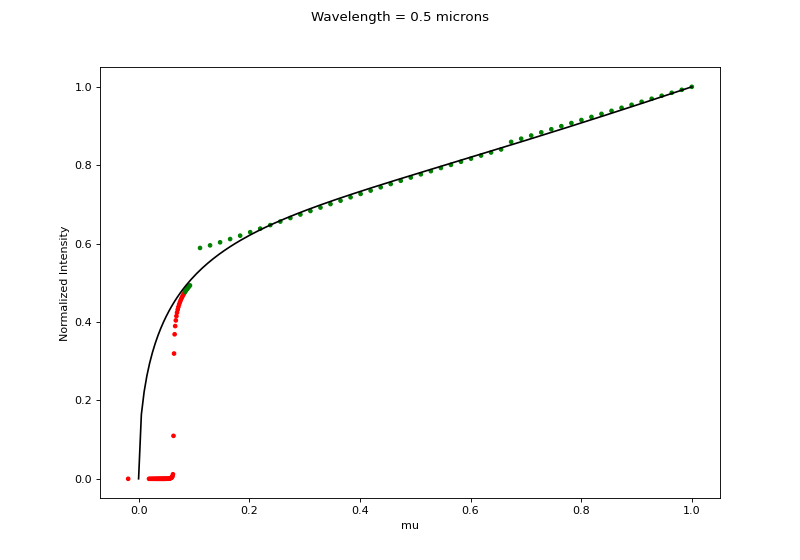

LD coeffs were: [ 3.01024508 -4.69539631  3.98945586 -1.30430462]
( Chi2 , Chi2_red ) was: (0.00015471002960582014, 2.81290962919673e-06)


<IPython.core.display.Javascript object>


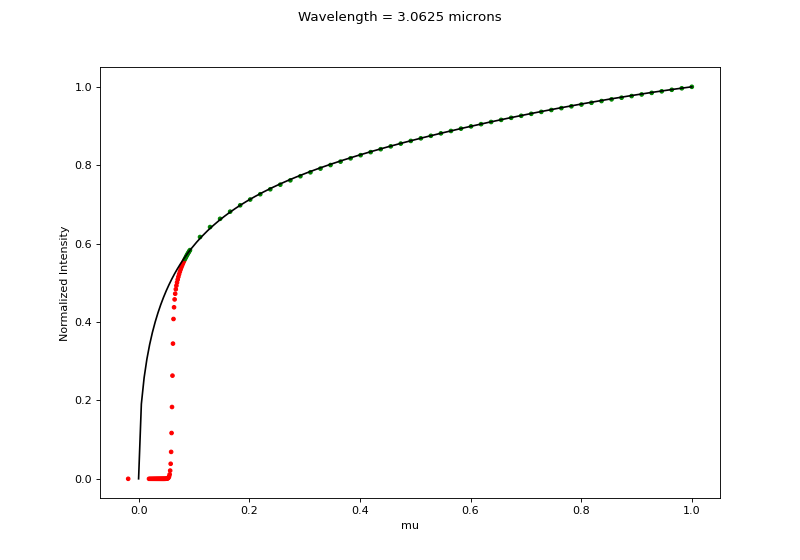

LD coeffs were: [ 3.66230999 -6.56736065  5.68707677 -1.86039294]
( Chi2 , Chi2_red ) was: (0.00016188069034958654, 2.9432852790833916e-06)


<IPython.core.display.Javascript object>


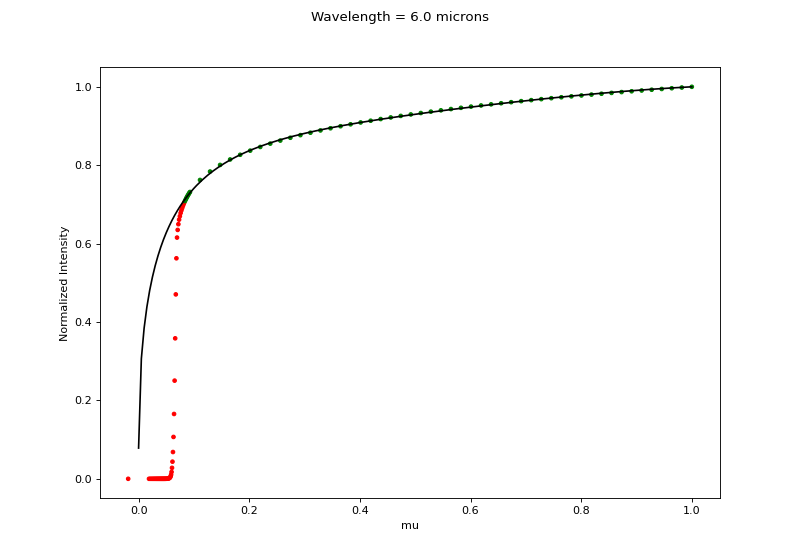

Total runtime to process this 2.15 GB PHOENIX model: 47m:34s


In [11]:
path = "/home/albert/www-/jwst/phoenix/"
filename = "lte02400-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5.gz"
wav_ref_file = "Ref_files/PHOENIX_wav_inds.npy"
out_path = ""
#new_fname = "lte04000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.simu-SOSS_auto-guesses_mu50.dat"
new_fname=None

ld_guess = [1,-1,1,-1]
#ld_guess=[ 1.24636614, -1.37265911,  2.08556316, -0.82031598]
#ld_guess = [ 3.78194662, -6.88011579,  6.65609794, -1.9836298 ]
#ld_guess = [ 0.98297048, -1.65501271,  1.53012258, -0.51994879 ]
ld_guess = []

PHOENIX_to_SOSS( path,filename , ld_guess=ld_guess , ld_bounds=(-np.inf,np.inf)
               , sosstar_fpath=out_path , sosstar_fname=new_fname
               , wl_inds=[None,None] , wl_range=[0.5e4,6e4]
               , mu_inds=[55,-1] , mu_range=[0.2,None] , I_range=[0.05,None]
               , doPrint=True , doPlot=True , save=True , delete_hdf5=False
               , force_positive_I=True , use_wav_ref_file=(True,wav_ref_file)
               )

# Observe the chi2 behaviour of a particular limb darkening fitting run

In [13]:
sosstar_path = "SOSS_starfiles/"
sosstar_file = "lte04000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.simu-SOSS_auto-guesses_mu50.dat"
data = np.loadtxt(sosstar_path+sosstar_file)
print(data.shape)

(1025001, 8)


17832


<IPython.core.display.Javascript object>


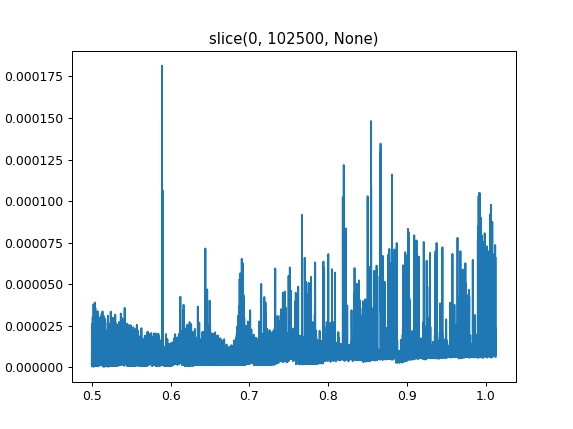

<IPython.core.display.Javascript object>


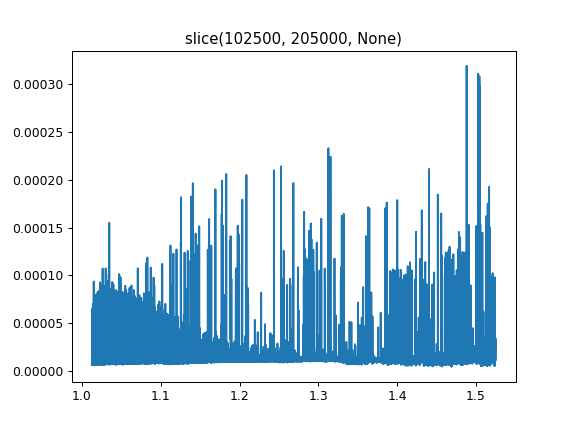

<IPython.core.display.Javascript object>


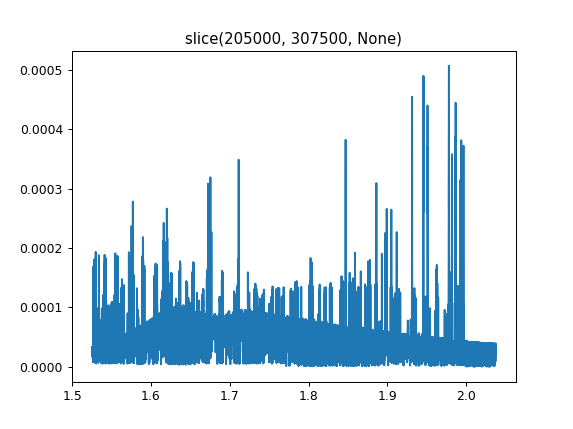

<IPython.core.display.Javascript object>


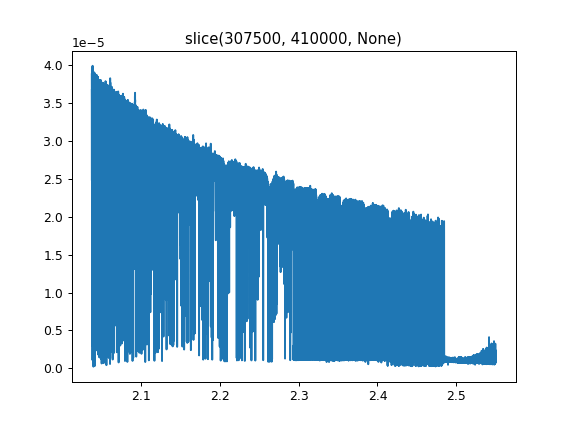

<IPython.core.display.Javascript object>


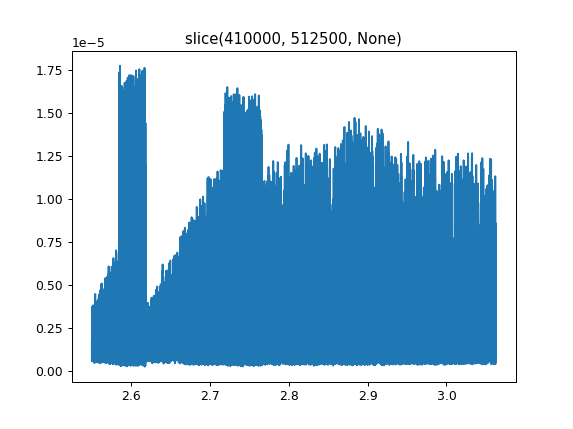

<IPython.core.display.Javascript object>


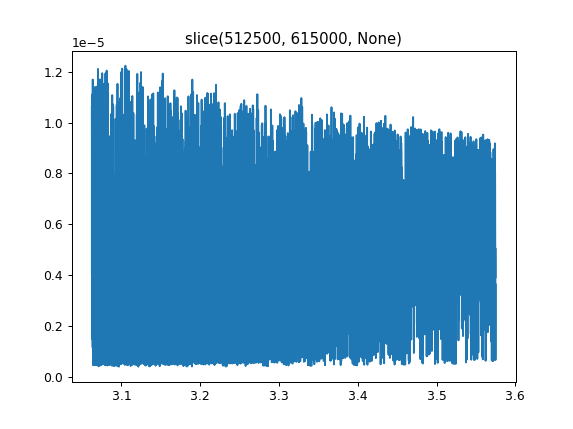

<IPython.core.display.Javascript object>


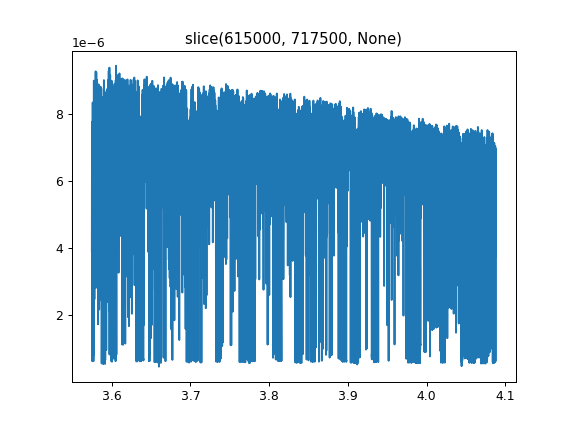

<IPython.core.display.Javascript object>


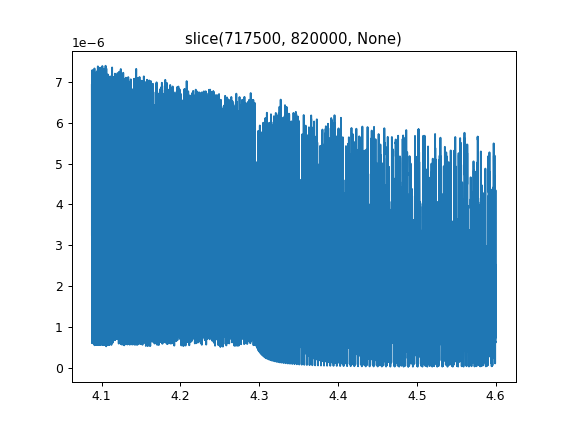

<IPython.core.display.Javascript object>


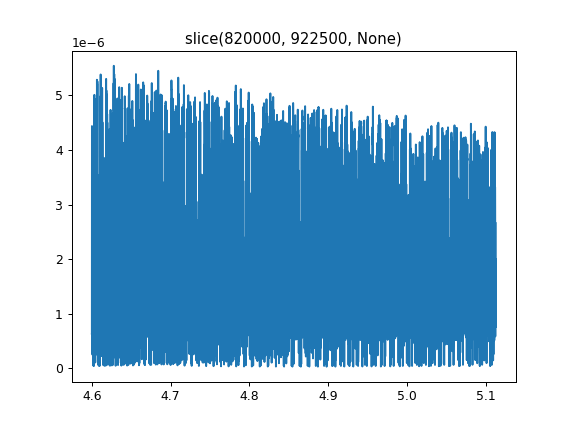

<IPython.core.display.Javascript object>


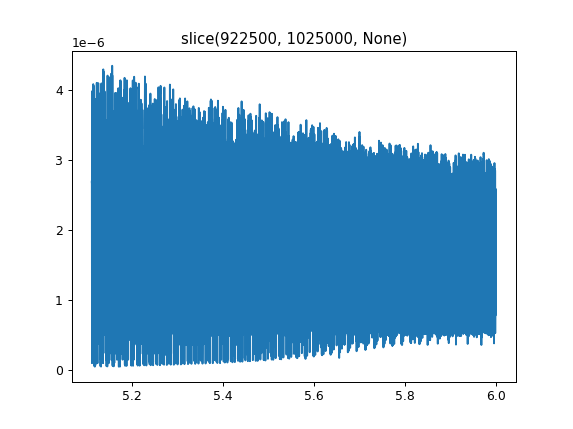

In [14]:
nplots = 10
len_data = len(data)
for i in range(nplots):
    slyce = slice( int(i*(len_data//nplots)) , int((i+1)*(len_data//nplots)) )
    if i==0:
        print(data[slyce,-1].argmax())
    red_chi2 = data[slyce,-1]
    plt.figure()
    plt.plot( data[slyce,0]/1e4 , red_chi2) #, data[slyce][-1] )
    plt.title(str(slyce))

# Test obtaining a stellar F_lambda spectrum from the generated .dat files

In [4]:
sosstar_path = "SOSS_starfiles/"
sosstar_file = "lte04000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.simu-SOSS_auto-guesses_mu50.dat"
starmodel_wv=[]
starmodel_flux=[]
ld_coeff=[]
f = open(sosstar_path+sosstar_file,'r')
for i,line in enumerate(f):
    line = line.strip() #get rid of \n at the end of the line
    columns = line.split() #break into columns with space delimiter
    starmodel_wv.append(float(columns[0]))
    flux=-float(columns[5])*np.pi*(42.0*float(columns[1])+70.0*float(columns[2])\
            +90.0*float(columns[3])+105.0*float(columns[4])-210.0)/210.0
    starmodel_flux.append(np.max([0.0,flux]))
    ld_coeff.append([float(columns[1]),float(columns[2]),float(columns[3])\
        ,float(columns[4])])
f.close()

<IPython.core.display.Javascript object>


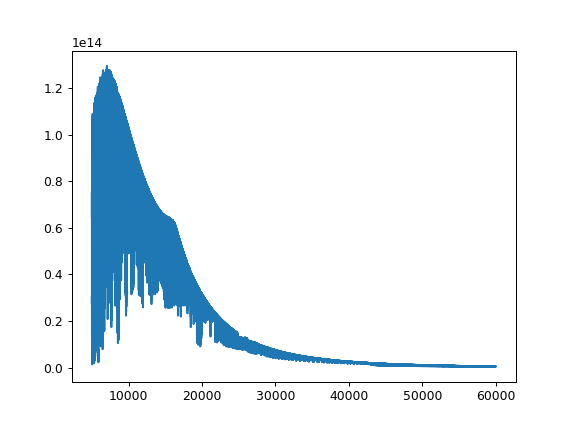

In [5]:
plt.figure()
plt.plot(starmodel_wv,starmodel_flux)

# (not done yet) Compare differences between spectrum obtained from integration of limb darkening coeffs vs. plotting the spectrum contained in the PHOENIX file. Useful to seehow the errors in the intensity profile fitting affect the obtained F_lambda spectrum

946476858794.3588
373700000000.0


<IPython.core.display.Javascript object>


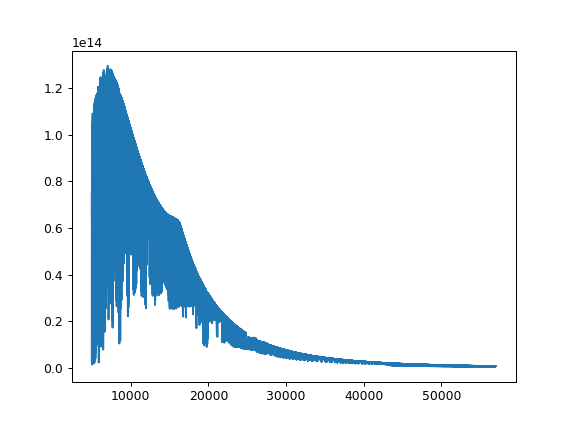

In [21]:
path = "/home/albert/www-/jwst/phoenix/"
filename = "lte04000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011.JWST-RF.h5"
indy = 50000
rang = slice(90000,1100000)

with h5py.File(filename) as f:
    group_key_phoenixRF = list(f.keys())[0]      # file only has a single key on first level
    data_group = f[group_key_phoenixRF]
    
    print(10**data_group['flux'][indy])
    print(data_group['Intensities'][indy][-1])
    
    plt.figure()
    plt.plot( data_group['wl'][rang] , 10**data_group['flux'][rang] )